# 模型选择

视频：https://www.bilibili.com/video/BV1kX4y1g7jp?spm_id_from=333.999.0.0

4.4章节：https://zh-v2.d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html 


·由于不能基于训练误差来估计泛化误差，因此简单地最小化训练误差并不一定意味着泛化误差的减小。机器学习模型需要注意防止过拟合，来使得泛化误差最小。

·验证集可以用于模型选择，但不能过于随意地使用它。

·欠拟合是指模型无法继续减少训练误差。过拟合是指训练误差远小于验证误差。

·我们应该选择一个复杂度适当的模型，避免使用数量不足的训练样本。

## 一 笔记

### 1.训练误差和泛化误差

>·**训练误差：模型在训练数据上的误差**    
>·**泛化误差：模型在新数据上的误差**  
>例子：
>>·在过去考试中的表现很好（训练误差）不代表未来考试一定好（泛化误差）  
>>·A通过背书在模考中拿到很好成绩  
>>·B知道答案后面的原因



### 2.验证数据集与测试数据集

>·**验证数据集：一个用来评估模型好坏的数据集（训练模型参数）**  
>>拿出50%的训练数据  
>>不要跟训练数据混在一起（未参加训练）

>·**测试数据集：只用一次的数据集（选择模型超参数）**
>>不能用于调参 



### K-则交叉验证（没有足够多数据时使用）
>·算法：
>>1.将数据集分割成K块  
>>2.For i = 1,2,...,K   使用第i块作为验证数据集，其余作为训练数据集   
>>3.报告K个验证集误差的平均

### 3.过拟合与欠拟合

>影响模型泛化因素：
>>1.可调整参数的数量。当可调整参数的数量（有时称为自由度）很大时，模型往往更容易过拟合  
>>2.参数采用的值。当权重的取值范围较大时，模型可能更容易过拟合  
>>3.训练样本的数量。即使你的模型很简单，也很容易过拟合只包含一两个样本的数据集。而过拟合一个有数百万个样本的数据集则需要一个极其灵活的模型。 
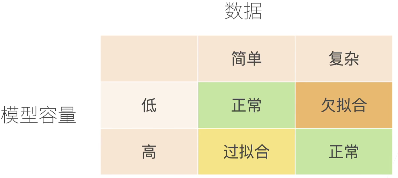


### **模型容量**
>·拟合各种函数的能力  
>·低容量的模型难以拟合训练数据  
>·高容量的模型可以记住所有的训练数据  
>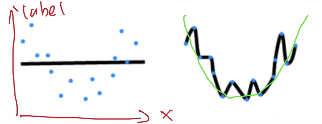
>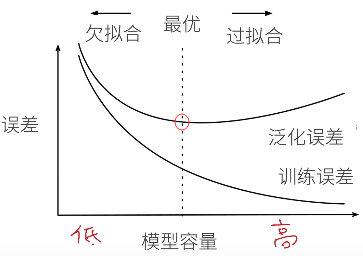



### 模型容量估计（VC维）
>支持N维输入的感知机的VC维是N + 1  
>一些多层感知机的VC维是O(NlogN)


---
---
---
## 二  代码

多项式回归

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 1.生成数据集

给定 x ，使用以下三阶多项式来生成训练和测试数据的标签
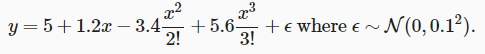
>噪声项 ϵ ：服从均值为0且标准差为0.1的正态分布

In [2]:
# 多项式的最大阶数，20维
max_degree = 20  

# 训练和测试数据集大小为100个样本
n_train, n_test = 100, 100  

# 分配大量的空间
true_w = np.zeros(max_degree)  
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # 其余为0噪音项


features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
    
    
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    d2l.float32) for x in [true_w, features, poly_features, labels]]


# 从生成的数据集中查看前2个样本
features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.4651],
         [0.2250]]),
 tensor([[1.0000e+00, 1.4651e+00, 1.0732e+00, 5.2414e-01, 1.9198e-01, 5.6253e-02,
          1.3736e-02, 2.8749e-03, 5.2650e-04, 8.5708e-05, 1.2557e-05, 1.6725e-06,
          2.0419e-07, 2.3013e-08, 2.4083e-09, 2.3522e-10, 2.1539e-11, 1.8563e-12,
          1.5109e-13, 1.1650e-14],
         [1.0000e+00, 2.2501e-01, 2.5315e-02, 1.8987e-03, 1.0681e-04, 4.8065e-06,
          1.8025e-07, 5.7942e-09, 1.6297e-10, 4.0744e-12, 9.1678e-14, 1.8753e-15,
          3.5164e-17, 6.0864e-19, 9.7821e-21, 1.4674e-22, 2.0636e-24, 2.7314e-26,
          3.4144e-28, 4.0435e-30]]),
 tensor([5.9908, 5.2027]))

### 2.对模型进行训练与测试

In [4]:
# 实现一个函数来评估模型在给定数据集上的损失

# 输入（网络，数据，损失函数）

def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    
    for X, y in data_iter:           #  取出样本(数据，标签)，分别赋值给X，y 
        out = net(X)                  # 将X放入网络进行预测得到输出
        y = y.reshape(out.shape)      # 将y的格式与网络预测结构格式变得一样
        
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]     # 返回平均损失

In [5]:
# 定义训练函数

# 输入（训练特征，测试特征，训练标签，测试标签，训练次数）

def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
   
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    
    #线性回归模型
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    
    
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### 3.三阶多项式函数拟合(正态)
后期训练集与测试集上的损失小 

后期训练集和测试集上的损失差异不大

weight: [[ 5.0004787  1.17364   -3.388064   5.62354  ]]


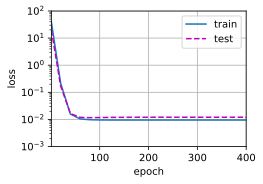

In [6]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### 4.线性函数拟合(欠拟合)
后期训练集上的损失大(损失几乎没降低）


weight: [[2.67452   6.0490327]]


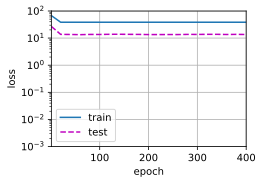

In [7]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### 5.高阶多项式函数拟合(过拟合)
验证集上的损失低于测试集上的损失，后期验证集上的损失变大

后期验证集损失与测试集损失差异大

weight: [[ 4.9978857   1.1845291  -3.352764    5.5168414  -0.24258162  0.4441516
   0.8176972  -0.22132015  0.31152582 -0.03366989  0.07179037  0.14731328
  -0.08671237  0.19583915  0.22296101 -0.17692418  0.18883479  0.03494021
  -0.02535843 -0.07050489]]


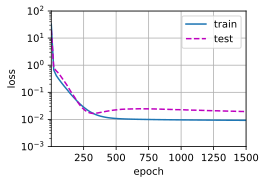

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)